In [31]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, FunctionTransformer, quantile_transform
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score

from models.prepareData import getData, convertData
from models.models import linearRegressionModel, PolynomialFeatures, polynomialRegression

In [32]:
data = getData('Bán căn hộ chung cư', 'Nguyễn Hữu Thọ', 'Phước Kiển', 'Nhà Bè')
# data = getData('Bán căn hộ chung cư', 'Nguyễn Hữu Cảnh', '22', 'Bình Thạnh')
# data = getData('Bán đất', 'Trần Văn Giàu', 'Lê Minh Xuân', 'Bình Chánh')
# data = getData('Bán đất', 'Vườn Lài', 'An Phú Đông', '12')
# data = getData('Bán nhà riêng', 'Quốc Lộ 13', 'Hiệp Bình Phước', 'Thủ Đức')
# data = getData('Bán nhà riêng', 'Phạm Văn Chiêu', '9', 'Gò Vấp')
# data = getData('Bán nhà riêng', 'Nguyễn Văn Quá', 'Đông Hưng Thuận', '12')
# data = getData('Bán nhà riêng', 'Quốc Lộ 13', 'Hiệp Bình Phước', 'Thủ Đức')
# data = getData('Bán đất', 'Nguyễn Thị Rành', 'Nhuận Đức', 'Củ Chi')

In [33]:
print("Sample data: ")
print("--------------------------------------------------------")
print(data.head())
print("--------------------------------------------------------")
print("Data Length: ", len(data))

Sample data: 
--------------------------------------------------------
             post_type   area  price          street        ward district  \
0  Bán căn hộ chung cư    2.0   2.60  Nguyễn Hữu Thọ  Phước Kiển   Nhà Bè   
1  Bán căn hộ chung cư   70.0   2.60  Nguyễn Hữu Thọ  Phước Kiển   Nhà Bè   
2  Bán căn hộ chung cư  100.0   2.15  Nguyễn Hữu Thọ  Phước Kiển   Nhà Bè   
3  Bán căn hộ chung cư   62.0   1.70  Nguyễn Hữu Thọ  Phước Kiển   Nhà Bè   
4  Bán căn hộ chung cư   93.0   3.80  Nguyễn Hữu Thọ  Phước Kiển   Nhà Bè   

  posted_date  
0  2021-04-14  
1  2021-04-14  
2  2021-04-13  
3  2021-04-13  
4  2021-04-14  
--------------------------------------------------------
Data Length:  763


In [34]:
# preporcess data:

# sort data in post_date order to drop old data has same area:
data = data.sort_values(by=['posted_date'])

# Drop duplicates:    
data = data.drop_duplicates(subset='area', keep='last', inplace=False)

In [35]:
# sort data by area to perform smoothing data:
data = data.sort_values(by=['area'])

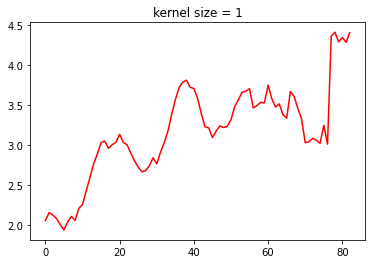

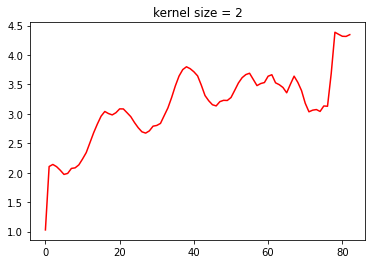

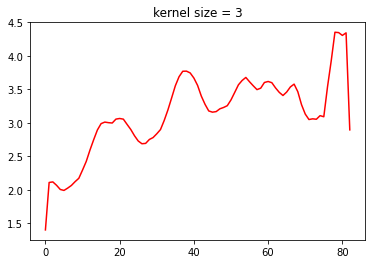

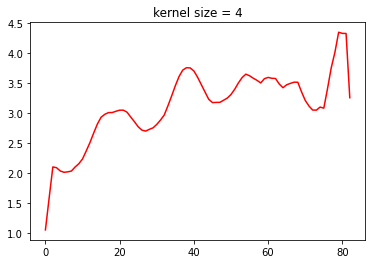

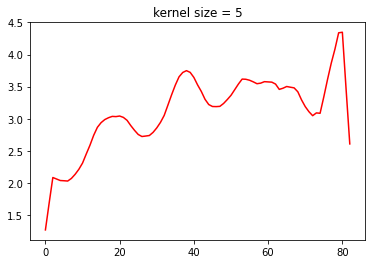

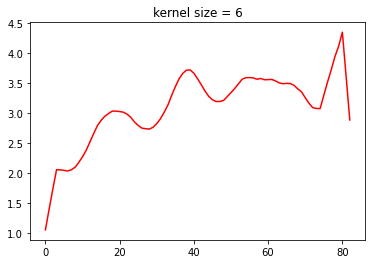

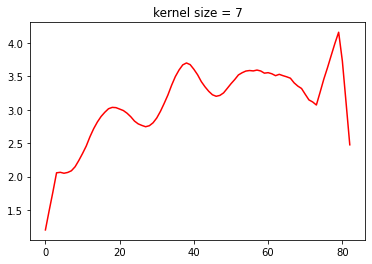

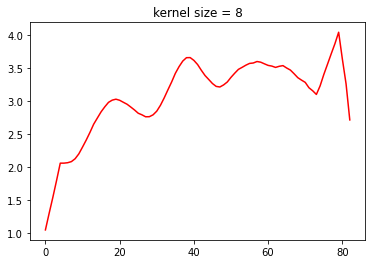

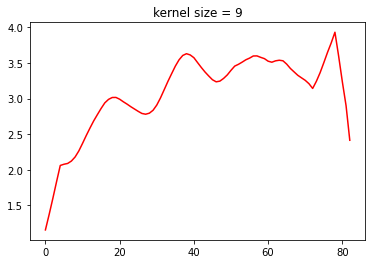

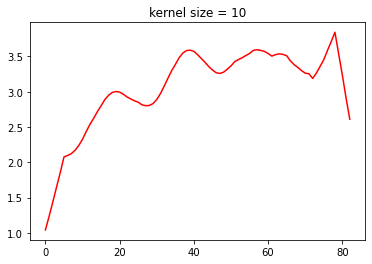

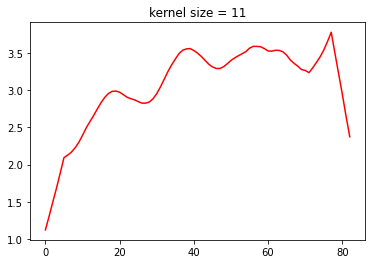

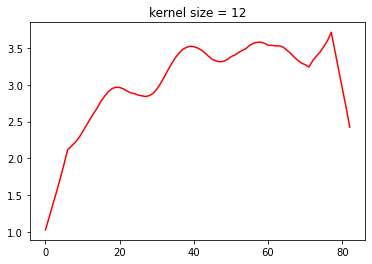

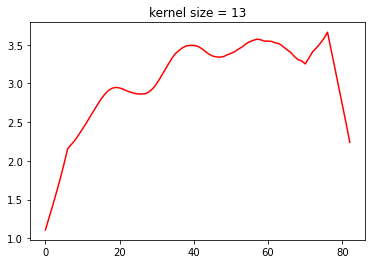

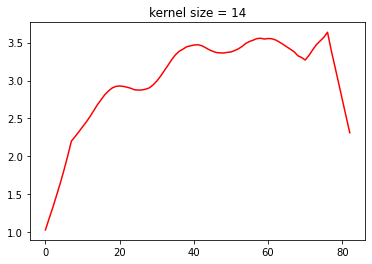

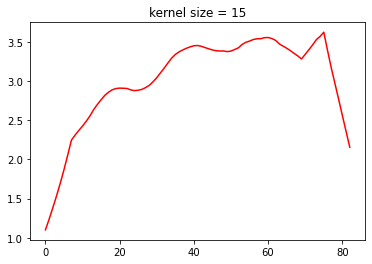

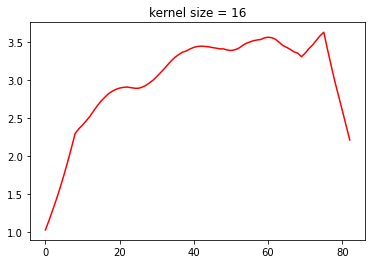

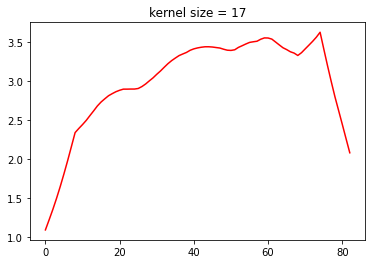

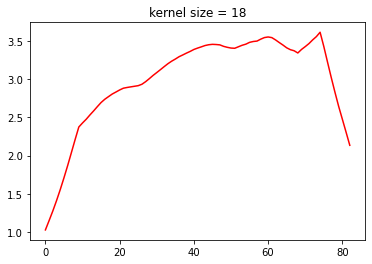

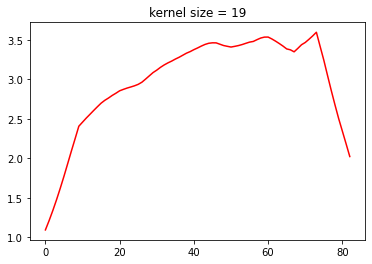

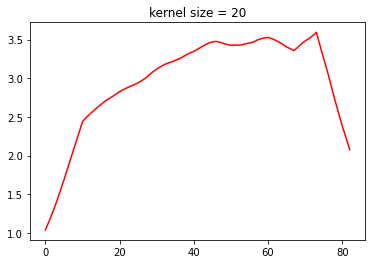

In [63]:
for i in range(1, 21):
    kernel = np.ones(i) / i
    prices = np.convolve(np.array(data['price']), kernel, mode='same')
#     plt.scatter(np.arange(len(data['price'])), np.array(data['price']), marker='o', color='black')
    plt.plot(prices, color='red')
    plt.title("kernel size = {}".format(i))
    plt.show()

In [37]:
# smooth data:
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size

# data['area'] = np.convolve(np.array(data['area']), kernel, mode='same')
data['price'] = np.convolve(np.array(data['price']), kernel, mode='same')

In [38]:
# remove outlier:
area_upper_bound = data['area'].quantile(0.9)
area_lower_bound = data['area'].quantile(0.1)
price_upper_bound = data['price'].quantile(0.9)
price_lower_bound = data['price'].quantile(0.1)

data = data[
    (data['area'] < area_upper_bound) &
    (data['area'] > area_lower_bound) &
    (data['price'] < price_upper_bound) &
    (data['price'] > price_lower_bound)
]

In [39]:
# divide data into train and test:
train_data, test_data = train_test_split(data, test_size=0.2)
train_data, validate_data = train_test_split(train_data, test_size=0.2)

In [40]:
# Sort data by area column:
train_data = train_data.sort_values(by=['area'])
test_data = test_data.sort_values(by=['area'])
validate_data = validate_data.sort_values(by=['area'])

print("\nTrain data length: ", len(train_data))
print("Test data length: ", len(test_data))
print("Validate data length: ", len(validate_data))


Train data length:  52
Test data length:  17
Validate data length:  14


In [41]:
# train_data['area'] = np.convolve(np.array(train_data['area']), kernel, mode='same')
# train_data['price'] = np.convolve(np.array(train_data['price']), kernel, mode='same')

# test_data['area'] = np.convolve(np.array(test_data['area']), kernel, mode='same')
# test_data['price'] = np.convolve(np.array(test_data['price']), kernel, mode='same')

# validate_data['area'] = np.convolve(np.array(validate_data['area']), kernel, mode='same')
# validate_data['price'] = np.convolve(np.array(validate_data['price']), kernel, mode='same')

In [42]:
# # convert data into numpy
X, Y = convertData(data)
X_train, Y_train = convertData(train_data)
X_test, Y_test = convertData(test_data)
X_validate, Y_validate = convertData(validate_data)

In [43]:
# scale data:

# Quantile Transformer:

# X = QuantileTransformer(n_quantiles=len(X_train), output_distribution='uniform').fit_transform(X)
# Y = QuantileTransformer(n_quantiles=len(Y_train), output_distribution='uniform').fit_transform(Y)

# X_train = QuantileTransformer(n_quantiles=len(X_train), output_distribution='uniform').fit_transform(X_train)
# Y_train = QuantileTransformer(n_quantiles=len(Y_train), output_distribution='uniform').fit_transform(Y_train)

# X_test = QuantileTransformer(n_quantiles=len(X_test), output_distribution='uniform').fit_transform(X_test)
# Y_test = QuantileTransformer(n_quantiles=len(X_test), output_distribution='uniform').fit_transform(Y_test)

# X_validate = QuantileTransformer(n_quantiles=len(X_validate), output_distribution='uniform').fit_transform(X_validate)
# Y_validate = QuantileTransformer(n_quantiles=len(Y_validate), output_distribution='uniform').fit_transform(Y_validate)

# Power Transformer:

# X = PowerTransformer(method='yeo-johnson').fit_transform(X)
# Y = PowerTransformer(method='yeo-johnson').fit_transform(Y)

# X_train = PowerTransformer(method='yeo-johnson').fit_transform(X_train)
# Y_train = PowerTransformer(method='yeo-johnson').fit_transform(Y_train)

# X_test = PowerTransformer(method='yeo-johnson').fit_transform(X_test)
# Y_test = PowerTransformer(method='yeo-johnson').fit_transform(Y_test)

# X_validate = PowerTransformer(method='yeo-johnson').fit_transform(X_validate)
# Y_validate = PowerTransformer(method='yeo-johnson').fit_transform(Y_validate)

# Log Transformer:

X = FunctionTransformer(np.log).fit_transform(X)
Y = FunctionTransformer(np.log).fit_transform(Y)

X_train = FunctionTransformer(np.log).fit_transform(X_train)
Y_train = FunctionTransformer(np.log).fit_transform(Y_train)

X_test = FunctionTransformer(np.log).fit_transform(X_test)
Y_test = FunctionTransformer(np.log).fit_transform(Y_test)

X_validate = FunctionTransformer(np.log).fit_transform(X_validate)
Y_validate = FunctionTransformer(np.log).fit_transform(Y_validate)

Text(0.5, 1.0, 'Y_validate')

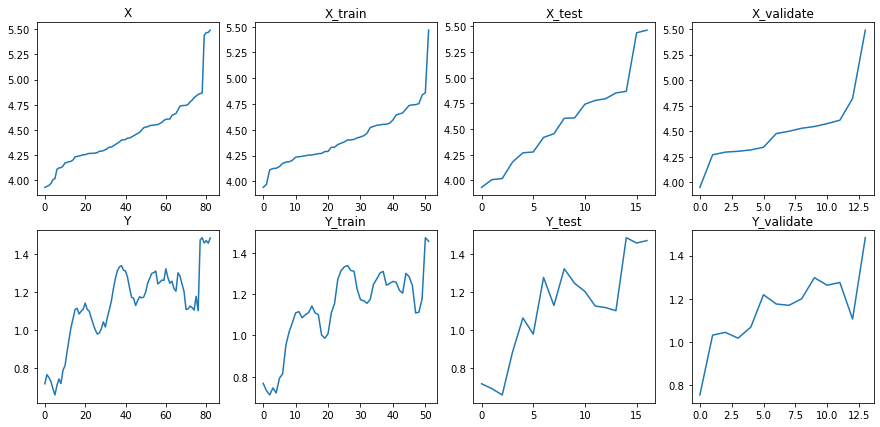

In [44]:
fig, ax = plt.subplots(2, 4, figsize=(15, 7))
ax[0][0].plot(X)
ax[0][0].set_title('X')
ax[0][1].plot(X_train)
ax[0][1].set_title('X_train')
ax[0][2].plot(X_test)
ax[0][2].set_title('X_test')
ax[0][3].plot(X_validate)
ax[0][3].set_title('X_validate')

ax[1][0].plot(Y)
ax[1][0].set_title('Y')
ax[1][1].plot(Y_train)
ax[1][1].set_title('Y_train')
ax[1][2].plot(Y_test)
ax[1][2].set_title('Y_test')
ax[1][3].plot(Y_validate)
ax[1][3].set_title('Y_validate')

In [45]:
# find model by using linear regression:
linear_model = linearRegressionModel(X_train, Y_train)

# find Y by using linear model predict:
Y_train_pred = linear_model.predict(X_train)
Y_test_pred = linear_model.predict(X_test)

# Calculate RMSE on train and test data:
train_linear_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
test_linear_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))


Linear Regression Model: 


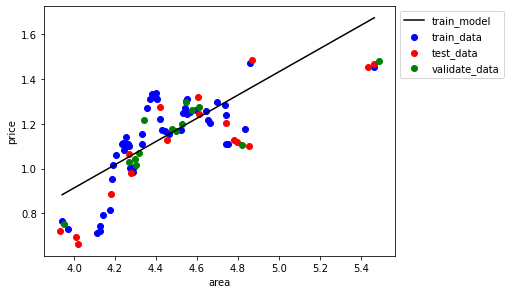

In [46]:
print("\nLinear Regression Model: ")
# Plot linear model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.show()

In [47]:
# Linear Model coefficient and intercept:
print("Linear model coefficient: {}".format(linear_model.coef_))
print("Linear model intercept: {}".format(linear_model.intercept_))

# linear_model rmse:
print("Linear model rmse on train data: {}".format(train_linear_rmse))
print("Linear model rmse on test data: {}".format(test_linear_rmse))
print("\n\n")

Linear model coefficient: [[0.51835061]]
Linear model intercept: [-1.1593418]
Linear model rmse on train data: 0.12555666077615474
Linear model rmse on test data: 0.16183921376533184





In [48]:
# find model by using polynomial regression:
poly_model, degree, train_rmse, validate_rmse, test_rmse = polynomialRegression(X, Y, X_train, Y_train, X_test, Y_test, X_validate, Y_validate)

# transform X and X_test:
polynomial_features = PolynomialFeatures(degree=degree)
X_train_poly = polynomial_features.fit_transform(X_train)
X_test_poly = polynomial_features.fit_transform(X_test)

# Try predicting Y
Y_train_poly_pred = poly_model.predict(X_train_poly)
Y_test_poly_pred = poly_model.predict(X_test_poly)

Polynomial Regression with degree = 4 and rmse = 0.0683312358530035
Regularized Regression with alpha = 1e-05 and rmse = 0.07783986209487295
Polynomial Regression cross validation score:  -4.585267954261343
Regularized Regression cross validation score:  -4.585254302914709


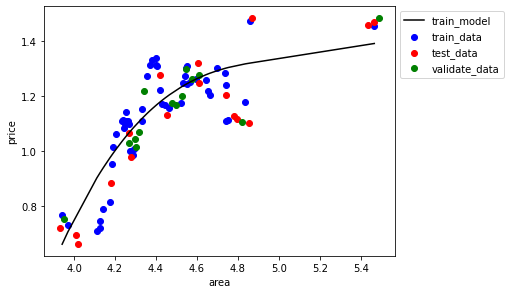

In [49]:
# Plot model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_poly_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.show()

In [50]:
print("Polynomial Regression with degree = {}\n".format(degree))
# Polynomial Model coefficient and intercept:
print("Polynomial model coefficient:")
print(poly_model.coef_)
print("Polynomial model intercept: {}\n".format(poly_model.intercept_))

# poly_model rmse:
print("Polynomial Model RMSE on train data: {}".format(train_rmse))
print("Polynomial Model RMSE on validate data: {}".format(validate_rmse))
print("Polynomial Model RMSE on test data: {}".format(test_rmse))

Polynomial Regression with degree = 4

Polynomial model coefficient:
[[ 0.         17.55189027 -1.61175072 -0.2578229   0.03593306]]
Polynomial model intercept: [-36.3643163]

Polynomial Model RMSE on train data: 0.10028214680103596
Polynomial Model RMSE on validate data: 0.07783986209487295
Polynomial Model RMSE on test data: 0.1150286613538632


In [51]:
# score the model with test data:

# Linear score:
print("\n")
print("Linear Model score on train dataset: ", linear_model.score(X_train, Y_train))
print("Linear Model score on test dataset: ", linear_model.score(X_test, Y_test))

# Poly score:
print("\n")
print("Poly Model score on train dataset: ", poly_model.score(X_train_poly, Y_train))
print("Poly Model score on test dataset: ", poly_model.score(X_test_poly, Y_test))



Linear Model score on train dataset:  0.5392012971538931
Linear Model score on test dataset:  0.5888924698293103


Poly Model score on train dataset:  0.706046267447397
Poly Model score on test dataset:  0.7923174328935598
